In [ ]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder \
#     .master('local[*]') \
#     .config("spark.driver.memory", "100G") \
#     .config("spark.EXECUTOR.memory", "100G") \
#     .appName('my-cool-app') \
#     .getOrCreate()

In [1]:
import pandas as pd
import numpy as np
import scipy
import os 

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression 
from sklearn import ensemble 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import brier_score_loss, precision_score, recall_score,f1_score, roc_auc_score, accuracy_score 
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import StandardScaler 
from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans

import random

from scipy.stats import ttest_ind

import time

In [2]:
import pandas as pd
#!!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

from pyspark.sql.functions import split
from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import when
from pyspark.sql.functions import col, when, count, lit

spark = SparkSession.builder.appName("PySpark create RDD example").config("spark.some.config.option", "some-value").getOrCreate()  

# a) Data - Loading Medicare Part D Prescribers - by Provider and Drug data

In [3]:
# a) Loading Medicare Part D Prescribers - by Provider and Drug data

# record start time
start = time.time()

df_partD_pd_test = spark.read.option("header",True) \
     .csv("MUP_DPR_RY22_P04_V10_DY20_NPIBN_0.csv")

#df_partD_pd = pd.read_csv("MUP_DPR_RY22_P04_V10_DY20_NPIBN_0 (1).csv",sep=",",encoding='latin-1')

# record end time
end = time.time()

# print the difference between start and end time in milli. secs
print("The time of execution of above program is :",(end-start) * 10**3, "ms")

The time of execution of above program is : 8572.671890258789 ms


In [4]:
df_partD_pd_test.take(2)

[Row(Prscrbr_NPI='1003000126', Prscrbr_Last_Org_Name='Enkeshafi', Prscrbr_First_Name='Ardalan', Prscrbr_City='Bethesda', Prscrbr_State_Abrvtn='MD', Prscrbr_State_FIPS='24', Prscrbr_Type='Internal Medicine', Prscrbr_Type_Src='S', Brnd_Name='Amiodarone Hcl', Gnrc_Name='Amiodarone Hcl', Tot_Clms='13', Tot_30day_Fills='13.8', Tot_Day_Suply='399', Tot_Drug_Cst='135.38', Tot_Benes=None, GE65_Sprsn_Flag=None, GE65_Tot_Clms='13', GE65_Tot_30day_Fills='13.8', GE65_Tot_Drug_Cst='135.38', GE65_Tot_Day_Suply='399', GE65_Bene_Sprsn_Flag='*', GE65_Tot_Benes=None),
 Row(Prscrbr_NPI='1003000126', Prscrbr_Last_Org_Name='Enkeshafi', Prscrbr_First_Name='Ardalan', Prscrbr_City='Bethesda', Prscrbr_State_Abrvtn='MD', Prscrbr_State_FIPS='24', Prscrbr_Type='Internal Medicine', Prscrbr_Type_Src='S', Brnd_Name='Amlodipine Besylate', Gnrc_Name='Amlodipine Besylate', Tot_Clms='13', Tot_30day_Fills='19', Tot_Day_Suply='570', Tot_Drug_Cst='42.47', Tot_Benes=None, GE65_Sprsn_Flag='*', GE65_Tot_Clms=None, GE65_Tot_30

In [5]:
df_partD_pd_test.show(2)

+-----------+---------------------+------------------+------------+--------------------+------------------+-----------------+----------------+-------------------+-------------------+--------+---------------+-------------+------------+---------+---------------+-------------+--------------------+-----------------+------------------+--------------------+--------------+
|Prscrbr_NPI|Prscrbr_Last_Org_Name|Prscrbr_First_Name|Prscrbr_City|Prscrbr_State_Abrvtn|Prscrbr_State_FIPS|     Prscrbr_Type|Prscrbr_Type_Src|          Brnd_Name|          Gnrc_Name|Tot_Clms|Tot_30day_Fills|Tot_Day_Suply|Tot_Drug_Cst|Tot_Benes|GE65_Sprsn_Flag|GE65_Tot_Clms|GE65_Tot_30day_Fills|GE65_Tot_Drug_Cst|GE65_Tot_Day_Suply|GE65_Bene_Sprsn_Flag|GE65_Tot_Benes|
+-----------+---------------------+------------------+------------+--------------------+------------------+-----------------+----------------+-------------------+-------------------+--------+---------------+-------------+------------+---------+---------------+--

In [6]:
df_partD_pd_test.printSchema()
df_partD_pd_test.columns

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Prscrbr_Type_Src: string (nullable = true)
 |-- Brnd_Name: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Clms: string (nullable = true)
 |-- Tot_30day_Fills: string (nullable = true)
 |-- Tot_Day_Suply: string (nullable = true)
 |-- Tot_Drug_Cst: string (nullable = true)
 |-- Tot_Benes: string (nullable = true)
 |-- GE65_Sprsn_Flag: string (nullable = true)
 |-- GE65_Tot_Clms: string (nullable = true)
 |-- GE65_Tot_30day_Fills: string (nullable = true)
 |-- GE65_Tot_Drug_Cst: string (nullable = true)
 |-- GE65_Tot_Day_Suply: string (nullable = true)
 |-- GE65_Bene_Sprsn_Flag: string (nullable = true)
 |-- GE65_Tot_Ben

['Prscrbr_NPI',
 'Prscrbr_Last_Org_Name',
 'Prscrbr_First_Name',
 'Prscrbr_City',
 'Prscrbr_State_Abrvtn',
 'Prscrbr_State_FIPS',
 'Prscrbr_Type',
 'Prscrbr_Type_Src',
 'Brnd_Name',
 'Gnrc_Name',
 'Tot_Clms',
 'Tot_30day_Fills',
 'Tot_Day_Suply',
 'Tot_Drug_Cst',
 'Tot_Benes',
 'GE65_Sprsn_Flag',
 'GE65_Tot_Clms',
 'GE65_Tot_30day_Fills',
 'GE65_Tot_Drug_Cst',
 'GE65_Tot_Day_Suply',
 'GE65_Bene_Sprsn_Flag',
 'GE65_Tot_Benes']

In [7]:
print((df_partD_pd_test.count(), len(df_partD_pd_test.columns)))

(25209729, 22)


In [8]:
df_partD_pd = df_partD_pd_test

In [9]:
partD_Drug_pd1 = df_partD_pd.select('Prscrbr_NPI',
                                   'Prscrbr_City',
                                   'Prscrbr_State_Abrvtn',
                                   'Prscrbr_State_FIPS',
                                   'Prscrbr_Last_Org_Name',
                                   'Prscrbr_First_Name',
                                   'Prscrbr_Type',
                                   'Brnd_Name',
                                   'Gnrc_Name',
                                   'Tot_Drug_Cst',
                                   'GE65_Tot_Clms',
                                   'GE65_Tot_Day_Suply')

In [10]:
print((partD_Drug_pd1.count(), len(partD_Drug_pd1.columns)))
partD_Drug_pd1.printSchema()

(25209729, 12)
root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Brnd_Name: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Drug_Cst: string (nullable = true)
 |-- GE65_Tot_Clms: string (nullable = true)
 |-- GE65_Tot_Day_Suply: string (nullable = true)



In [11]:
df_partD_pd_1 = partD_Drug_pd1

In [12]:
partD_Drug_pd = df_partD_pd.select('Prscrbr_NPI',
                                   'Gnrc_Name',
                                   'Tot_Drug_Cst',
                                   'GE65_Tot_Clms',
                                   'GE65_Tot_Day_Suply',
                                   'Prscrbr_Type')
partD_Drug_pd.printSchema()
#partD_Drug_pd.head(5)

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Drug_Cst: string (nullable = true)
 |-- GE65_Tot_Clms: string (nullable = true)
 |-- GE65_Tot_Day_Suply: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)



In [13]:
partD_Spec_pd1 = df_partD_pd.select('Prscrbr_NPI','Prscrbr_Type')
partD_Spec_pd1.printSchema()
#partD_Spec_pd1.head(5)

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)



In [14]:
partD_pd0 = df_partD_pd.select('Prscrbr_NPI',
                               'Prscrbr_City',
                               'Prscrbr_State_Abrvtn',
                               'Prscrbr_State_FIPS',
                               'Prscrbr_Last_Org_Name',
                               'Prscrbr_First_Name',
                               'Prscrbr_Type')
partD_pd0.printSchema()
#print((partD_Drug_pd1.count(), len(partD_Drug_pd1.columns)))
#partD_pd0.head(5)

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)



In [15]:
partD_catfpd = partD_pd0.dropDuplicates()
print((partD_catfpd.count(), len(partD_catfpd.columns)))
#partD_catfpd.head(5)

(983636, 7)


In [16]:
rename_col = ['Prscrbr_NPI',
              'city',
              'state',
              'Prscrbr_State_FIPS',
              'last_name',
              'first_name',
              'Speciality']
partD_catfpd = partD_catfpd.toDF(*rename_col)

partD_catfpd.printSchema()

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- Speciality: string (nullable = true)



In [17]:
#print((partD_catfpd.count(), len(partD_catfpd.columns)))
#partD_catfpd.head(5)

In [18]:
df_partD_pd_1.printSchema()

cols = ['Tot_Drug_Cst','GE65_Tot_Clms','GE65_Tot_Day_Suply']
for col_name in cols:
    df_partD_pd_1 = df_partD_pd_1.withColumn(col_name, col(col_name).cast('double'))

df_partD_pd_1.printSchema()

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Brnd_Name: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Drug_Cst: string (nullable = true)
 |-- GE65_Tot_Clms: string (nullable = true)
 |-- GE65_Tot_Day_Suply: string (nullable = true)

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Prscrbr_City: string (nullable = true)
 |-- Prscrbr_State_Abrvtn: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- Prscrbr_Last_Org_Name: string (nullable = true)
 |-- Prscrbr_First_Name: string (nullable = true)
 |-- Prscrbr_Type: string (nullable = true)
 |-- Brnd_Name: string (nullable = true)
 |-- Gnrc_Name: string (nullable = true)
 |-- Tot_Drug_

In [19]:
#df_partD_pd_1.head(1)

In [20]:
partD_fpd = df_partD_pd_1.groupby('Prscrbr_NPI') \
            .agg(F.sum("Tot_Drug_Cst").alias('Tot_Drug_Cst_sum'),
                 F.avg('Tot_Drug_Cst').alias('Tot_Drug_Cst_mean'),
                 F.max('Tot_Drug_Cst').alias('Tot_Drug_Cst_max'),
                 F.sum('GE65_Tot_Clms').alias('GE65_Tot_Clms_sum'),
                 F.avg('GE65_Tot_Clms').alias('GE65_Tot_Clms_mean'),
                 F.max('GE65_Tot_Clms').alias('GE65_Tot_Clms_max'),
                 F.sum('GE65_Tot_Day_Suply').alias('GE65_Tot_Day_Suply_sum'),
                 F.avg('GE65_Tot_Day_Suply').alias('GE65_Tot_Day_Suply_mean'),
                 F.max('GE65_Tot_Day_Suply').alias('GE65_Tot_Day_Suply_max'),
                )

In [21]:
partD_fpd.show(5)

+-----------+------------------+------------------+----------------+-----------------+------------------+-----------------+----------------------+-----------------------+----------------------+
|Prscrbr_NPI|  Tot_Drug_Cst_sum| Tot_Drug_Cst_mean|Tot_Drug_Cst_max|GE65_Tot_Clms_sum|GE65_Tot_Clms_mean|GE65_Tot_Clms_max|GE65_Tot_Day_Suply_sum|GE65_Tot_Day_Suply_mean|GE65_Tot_Day_Suply_max|
+-----------+------------------+------------------+----------------+-----------------+------------------+-----------------+----------------------+-----------------------+----------------------+
| 1003017104|           4853.84|           4853.84|         4853.84|              0.0|               0.0|              0.0|                   0.0|                    0.0|                   0.0|
| 1003017906|237115.20000000004|2155.5927272727276|        34285.12|           2656.0| 47.42857142857143|            284.0|              166189.0|      2967.660714285714|               22420.0|
| 1003075516| 313636.859999999

In [22]:
partD_allpd = partD_fpd.join(partD_catfpd, on='Prscrbr_NPI', how='left_outer') #https://learn.microsoft.com/en-us/azure/databricks/getting-started/dataframes-python

print((partD_allpd.count(), len(partD_allpd.columns)))
partD_allpd.printSchema()
partD_allpd.show(1)

(983636, 16)
root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Tot_Drug_Cst_sum: double (nullable = true)
 |-- Tot_Drug_Cst_mean: double (nullable = true)
 |-- Tot_Drug_Cst_max: double (nullable = true)
 |-- GE65_Tot_Clms_sum: double (nullable = true)
 |-- GE65_Tot_Clms_mean: double (nullable = true)
 |-- GE65_Tot_Clms_max: double (nullable = true)
 |-- GE65_Tot_Day_Suply_sum: double (nullable = true)
 |-- GE65_Tot_Day_Suply_mean: double (nullable = true)
 |-- GE65_Tot_Day_Suply_max: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- Speciality: string (nullable = true)

+-----------+----------------+-----------------+----------------+-----------------+------------------+-----------------+----------------------+-----------------------+----------------------+------------------+-----+------------------+

# b) Data - Loading Payment dataset

In [23]:
# b) Loading Payment Data

# record start time
start = time.time()

payment_pd = spark.read.option("header",True).csv("OP_DTL_GNRL_PGYR2020_P01202023.csv")

# record end time
end = time.time()

# print the difference between start and end time in milli. secs
print("The time of execution of above program is :",(end-start) * 10**3, "ms")

The time of execution of above program is : 323.9023685455322 ms


In [24]:
print((payment_pd.count(), len(payment_pd.columns)))
payment_pd.printSchema()

(5823162, 91)
root
 |-- Change_Type: string (nullable = true)
 |-- Covered_Recipient_Type: string (nullable = true)
 |-- Teaching_Hospital_CCN: string (nullable = true)
 |-- Teaching_Hospital_ID: string (nullable = true)
 |-- Teaching_Hospital_Name: string (nullable = true)
 |-- Covered_Recipient_Profile_ID: string (nullable = true)
 |-- Covered_Recipient_NPI: string (nullable = true)
 |-- Covered_Recipient_First_Name: string (nullable = true)
 |-- Covered_Recipient_Middle_Name: string (nullable = true)
 |-- Covered_Recipient_Last_Name: string (nullable = true)
 |-- Covered_Recipient_Name_Suffix: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line1: string (nullable = true)
 |-- Recipient_Primary_Business_Street_Address_Line2: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Recipient_Zip_Code: string (nullable = true)
 |-- Recipient_Country: string (nullable = true)
 |-- Recipient_Provin

In [25]:
payment_pd.show(n=1,vertical = True)

-RECORD 0---------------------------------------------------------------------------------
 Change_Type                                                       | UNCHANGED            
 Covered_Recipient_Type                                            | Covered Recipient... 
 Teaching_Hospital_CCN                                             | null                 
 Teaching_Hospital_ID                                              | null                 
 Teaching_Hospital_Name                                            | null                 
 Covered_Recipient_Profile_ID                                      | 557946               
 Covered_Recipient_NPI                                             | 1841302403           
 Covered_Recipient_First_Name                                      | Vikas                
 Covered_Recipient_Middle_Name                                     | Kumar                
 Covered_Recipient_Last_Name                                       | Pilly                

In [26]:
payment_fpd = payment_pd.select('Covered_Recipient_First_Name',
                                'Covered_Recipient_Last_Name',
                                'Recipient_City',
                                'Recipient_State',
                                'Total_Amount_of_Payment_USDollars')

#print((payment_fpd.count(), len(payment_fpd.columns)))
#payment_fpd.printSchema()
payment_fpd.show(1)

+----------------------------+---------------------------+--------------+---------------+---------------------------------+
|Covered_Recipient_First_Name|Covered_Recipient_Last_Name|Recipient_City|Recipient_State|Total_Amount_of_Payment_USDollars|
+----------------------------+---------------------------+--------------+---------------+---------------------------------+
|                       Vikas|                      Pilly| Williamsville|             NY|                         14875.00|
+----------------------------+---------------------------+--------------+---------------+---------------------------------+
only showing top 1 row



In [27]:
print("Count of non nulls for each column:")
payment_fpd.select([count(when(col(c).isNotNull() , c)).alias(c) for c in payment_fpd.columns]).show(vertical = True)

print("\nCount of nulls in dataframe for each column:")
payment_fpd.select([count(when(col(c).isNull(),c)).alias(c) for c in payment_fpd.columns]).show(vertical = True)

Count of non nulls for each column:
-RECORD 0------------------------------------
 Covered_Recipient_First_Name      | 5790756 
 Covered_Recipient_Last_Name       | 5790756 
 Recipient_City                    | 5823162 
 Recipient_State                   | 5822918 
 Total_Amount_of_Payment_USDollars | 5823162 


Count of nulls in dataframe for each column:
-RECORD 0----------------------------------
 Covered_Recipient_First_Name      | 32406 
 Covered_Recipient_Last_Name       | 32406 
 Recipient_City                    | 0     
 Recipient_State                   | 244   
 Total_Amount_of_Payment_USDollars | 0     



In [28]:
payment_fpd.printSchema()

cols = ['Total_Amount_of_Payment_USDollars']
for col_name in cols:
    payment_fpd_1 = payment_fpd.withColumn(col_name, col(col_name).cast('double'))

payment_fpd_1.printSchema()

root
 |-- Covered_Recipient_First_Name: string (nullable = true)
 |-- Covered_Recipient_Last_Name: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Total_Amount_of_Payment_USDollars: string (nullable = true)

root
 |-- Covered_Recipient_First_Name: string (nullable = true)
 |-- Covered_Recipient_Last_Name: string (nullable = true)
 |-- Recipient_City: string (nullable = true)
 |-- Recipient_State: string (nullable = true)
 |-- Total_Amount_of_Payment_USDollars: double (nullable = true)



In [29]:
payment_fpd1 = payment_fpd_1.groupby(['Covered_Recipient_First_Name',
                                      'Covered_Recipient_Last_Name',
                                      'Recipient_City',
                                      'Recipient_State']) \
               .agg(F.sum("Total_Amount_of_Payment_USDollars").alias('Total_Amount_of_Payment_USDollars_sum'))

rename_col = ['first_name',
              'last_name',
              'city',
              'state',
              'Total_Payment_Sum']

payment_fpd1 = payment_fpd1.toDF(*rename_col)

print((payment_fpd1.count(), len(payment_fpd1.columns)))
payment_fpd1.show(5)

(800852, 5)
+----------+-----------+----------+-----+------------------+
|first_name|  last_name|      city|state| Total_Payment_Sum|
+----------+-----------+----------+-----+------------------+
|      OMID|      SHAYE|WEST HILLS|   CA|216.48000000000002|
|   KENNETH| BLANKSTEIN|FLEMINGTON|   NJ| 570.2599999999999|
| SWEE JIAN|      NGEOW|FLEMINGTON|   NJ|            517.78|
|      MARK|STONECYPHER| MARYVILLE|   TN|            3465.0|
|   michael|     Verber| Camp Hill|   PA|            162.01|
+----------+-----------+----------+-----+------------------+
only showing top 5 rows



In [30]:
payment_fpd2 = payment_fpd1.sort(col('Total_Payment_Sum').asc())
payment_fpd2.show(2)

+----------+---------+--------------+------+-----------------+
|first_name|last_name|          city| state|Total_Payment_Sum|
+----------+---------+--------------+------+-----------------+
|     James|    Smith|"Raleigh","NC"| 27615|             null|
|    JUSTIN|      KOH|   SUITE 4B"""|BOSTON|             null|
+----------+---------+--------------+------+-----------------+
only showing top 2 rows



In [31]:
#print((payment_fpd2.count(), len(payment_fpd2.columns)))
#payment_fpd2.show(5)

In [32]:
# payment_fpd2.tail(5)

In [33]:
for col in payment_fpd2.columns:
    if (str(payment_fpd2.schema[col].dataType) == "StringType()"):
        #print( col + " is 'string' column")
        payment_fpd2 = payment_fpd2.withColumn(col, F.upper(F.col(col)))
    #else:
        #print( col + " is not - 'string' column")

payment_fpd2.show(2)

+----------+---------+--------------+-------------------+-----------------+
|first_name|last_name|          city|              state|Total_Payment_Sum|
+----------+---------+--------------+-------------------+-----------------+
|   KRISTEN|  PLOETZE|          WUSM| CAMPUS BOX 8233"""|             null|
|     JAMES|    SMITH|"RALEIGH","NC"|              27615|             null|
+----------+---------+--------------+-------------------+-----------------+
only showing top 2 rows



In [34]:
#print(payment_fpd2.printSchema())
#print(payment_fpd2.describe().show())
#payment_fpd2.tail(5)

In [35]:
partD_allpd.where((partD_allpd.first_name == 'Indira') & 
                  (partD_allpd.last_name == 'Molai')).show()

+-----------+-----------------+-----------------+----------------+-----------------+------------------+-----------------+----------------------+-----------------------+----------------------+---------+-----+------------------+---------+----------+-----------------+
|Prscrbr_NPI| Tot_Drug_Cst_sum|Tot_Drug_Cst_mean|Tot_Drug_Cst_max|GE65_Tot_Clms_sum|GE65_Tot_Clms_mean|GE65_Tot_Clms_max|GE65_Tot_Day_Suply_sum|GE65_Tot_Day_Suply_mean|GE65_Tot_Day_Suply_max|     city|state|Prscrbr_State_FIPS|last_name|first_name|       Speciality|
+-----------+-----------------+-----------------+----------------+-----------------+------------------+-----------------+----------------------+-----------------------+----------------------+---------+-----+------------------+---------+----------+-----------------+
| 1992999551|333988.2699999997|3180.840666666664|        70072.57|           2430.0| 37.38461538461539|            274.0|              163508.0|      2515.507692307692|               21580.0|Escondido| 

In [36]:
# Row(first_name='AARON', last_name='BEREZ', city='MOUNTAIN VIEW', state='CA', Total_Payment_Sum=20008737.76)

payment_fpd.where((payment_fpd.Covered_Recipient_First_Name == 'Indira') & 
                  (payment_fpd.Covered_Recipient_Last_Name == 'Molai')).show()

#& (payment_fpd2.city == 'Oroville')
# npifraud_pd0.where(F.col('NPI') == 0).count())

+----------------------------+---------------------------+--------------+---------------+---------------------------------+
|Covered_Recipient_First_Name|Covered_Recipient_Last_Name|Recipient_City|Recipient_State|Total_Amount_of_Payment_USDollars|
+----------------------------+---------------------------+--------------+---------------+---------------------------------+
|                      Indira|                      Molai|     Escondido|             CA|                            18.35|
+----------------------------+---------------------------+--------------+---------------+---------------------------------+



In [37]:
payment_fpd1.where((payment_fpd1.first_name == "Indira") & 
                   (payment_fpd1.last_name == "Molai")).show()

+----------+---------+---------+-----+-----------------+
|first_name|last_name|     city|state|Total_Payment_Sum|
+----------+---------+---------+-----+-----------------+
|    Indira|    Molai|Escondido|   CA|            18.35|
+----------+---------+---------+-----+-----------------+



In [38]:
payment_fpd2.where((payment_fpd2.first_name == "Indira") & 
                   (payment_fpd2.last_name == "Molai")).show()

+----------+---------+----+-----+-----------------+
|first_name|last_name|city|state|Total_Payment_Sum|
+----------+---------+----+-----+-----------------+
+----------+---------+----+-----+-----------------+



In [39]:
payment_fpd2.where((payment_fpd2.first_name == "INDIRA") & 
                   (payment_fpd2.last_name == "MOLAI")).show()

+----------+---------+---------+-----+-----------------+
|first_name|last_name|     city|state|Total_Payment_Sum|
+----------+---------+---------+-----+-----------------+
|    INDIRA|    MOLAI|ESCONDIDO|   CA|            18.35|
|    INDIRA|    MOLAI|ESCONDIDO|   CA|             79.5|
+----------+---------+---------+-----+-----------------+



In [40]:
print(payment_fpd1.describe().show())

+-------+----------+----------------+-----------------+-------------------+--------------------+
|summary|first_name|       last_name|             city|              state|   Total_Payment_Sum|
+-------+----------+----------------+-----------------+-------------------+--------------------+
|  count|    799525|          799525|           800852|             800782|              800849|
|   mean|       NaN|             NaN|           6295.0|            27615.0|   2617.548061382439|
| stddev|       NaN|             NaN|8036.975674966299|               null|  201242.05451209444|
|    min|  .JEFFREY|A VENKATARAMANAN|      SUITE 4B"""| CAMPUS BOX 8233"""|                0.01|
|    max|     zaven|         youssef|       youngstown|                 WY|1.4961652114000002E8|
+-------+----------+----------------+-----------------+-------------------+--------------------+

None


In [41]:
payment_pd.where((payment_pd.Covered_Recipient_Last_Name == 'Molai') & 
                 (payment_pd.Covered_Recipient_First_Name == 'Indira')).show()

+-----------+----------------------+---------------------+--------------------+----------------------+----------------------------+---------------------+----------------------------+-----------------------------+---------------------------+-----------------------------+-----------------------------------------------+-----------------------------------------------+--------------+---------------+------------------+-----------------+------------------+---------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+--------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-------------------------------------+-------------------------------------+-------------------------------------+---------------------------------

In [42]:
col_list = ['first_name','last_name','city','state']

for col in col_list:
    if (str(partD_allpd.schema[col].dataType) == "StringType()"):
        #print( col + " is 'string' column")
        partD_allpd = partD_allpd.withColumn(col, F.upper(F.col(col)))
    #else:
        #print( col + " is not - 'string' column")

#partD_allpd.show(5)

In [43]:
# join the part D dataset & payment dataset
pay_partD_fpd = partD_allpd.join(payment_fpd2, how ='left', on = ['last_name','first_name','city','state'])

pay_partD_fpd = pay_partD_fpd.select('Prscrbr_NPI',
                                     'Tot_Drug_Cst_sum',
                                     'Tot_Drug_Cst_mean',
                                     'Tot_Drug_Cst_max',
                                     'GE65_Tot_Clms_sum',
                                     'GE65_Tot_Clms_mean',
                                     'GE65_Tot_Clms_max',
                                     'GE65_Tot_Day_Suply_sum',
                                     'GE65_Tot_Day_Suply_mean',
                                     'GE65_Tot_Day_Suply_max',
                                     'city',
                                     'state',
                                     'Prscrbr_State_FIPS',
                                     'last_name',
                                     'first_name',
                                     'Speciality',
                                     'Total_Payment_Sum')

#print((pay_partD_fpd.count(), len(pay_partD_fpd.columns)))
pay_partD_fpd.printSchema()
# pay_partD_fpd.show(1)

root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Tot_Drug_Cst_sum: double (nullable = true)
 |-- Tot_Drug_Cst_mean: double (nullable = true)
 |-- Tot_Drug_Cst_max: double (nullable = true)
 |-- GE65_Tot_Clms_sum: double (nullable = true)
 |-- GE65_Tot_Clms_mean: double (nullable = true)
 |-- GE65_Tot_Clms_max: double (nullable = true)
 |-- GE65_Tot_Day_Suply_sum: double (nullable = true)
 |-- GE65_Tot_Day_Suply_mean: double (nullable = true)
 |-- GE65_Tot_Day_Suply_max: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- Speciality: string (nullable = true)
 |-- Total_Payment_Sum: double (nullable = true)



In [44]:
#print(pay_partD_fpd.describe().show())

In [45]:
# print("Count of non nulls for each column:")
# pay_partD_fpd.select([count(c).alias(c) for c in pay_partD_fpd.columns]).show(vertical = True)

# print("\nCount of nulls in dataframe for each column:")
# pay_partD_fpd.select([count(when(F.col(c).isNull(),c)).alias(c) for c in pay_partD_fpd.columns]).show(vertical = True)

# c) Data - Loading LEIE Data

In [46]:
# c) Loading LEIE Data

# record start time
start = time.time()

IELE_pd = spark.read.option("header",True).csv("LEIE.csv")

# record end time
end = time.time()

# print the difference between start and end time in milli. secs
print("The time of execution of above program is :",(end-start) * 10**3, "ms")

The time of execution of above program is : 256.50596618652344 ms


In [47]:
IELE_pd.printSchema()
print((IELE_pd.count(), len(IELE_pd.columns)))
IELE_pd.head(2)

root
 |-- LASTNAME: string (nullable = true)
 |-- FIRSTNAME: string (nullable = true)
 |-- MIDNAME: string (nullable = true)
 |-- BUSNAME: string (nullable = true)
 |-- GENERAL: string (nullable = true)
 |-- SPECIALTY: string (nullable = true)
 |-- UPIN: string (nullable = true)
 |-- NPI: string (nullable = true)
 |-- DOB: string (nullable = true)
 |-- ADDRESS: string (nullable = true)
 |-- CITY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- ZIP: string (nullable = true)
 |-- EXCLTYPE: string (nullable = true)
 |-- EXCLDATE: string (nullable = true)
 |-- REINDATE: string (nullable = true)
 |-- WAIVERDATE: string (nullable = true)
 |-- WVRSTATE: string (nullable = true)

(77164, 18)


[Row(LASTNAME=None, FIRSTNAME=None, MIDNAME=' ', BUSNAME='#1 MARKETING SERVICE, INC', GENERAL='OTHER BUSINESS', SPECIALTY='SOBER HOME', UPIN=None, NPI='0000000000', DOB=None, ADDRESS='239 BRIGHTON BEACH AVENUE', CITY='BROOKLYN', STATE='NY', ZIP='11235', EXCLTYPE='1128a1', EXCLDATE='20200319', REINDATE='00000000', WAIVERDATE='00000000', WVRSTATE=None),
 Row(LASTNAME=None, FIRSTNAME=None, MIDNAME=' ', BUSNAME='101 FIRST CARE PHARMACY INC', GENERAL='OTHER BUSINESS', SPECIALTY='PHARMACY', UPIN=None, NPI='1972902351', DOB=None, ADDRESS='C/O 609 W 191ST STREET, APT D', CITY='NEW YORK', STATE='NY', ZIP='10040', EXCLTYPE='1128b8', EXCLDATE='20220320', REINDATE='00000000', WAIVERDATE='00000000', WVRSTATE=None)]

In [48]:
npifraud_pd0 = IELE_pd.select('NPI','EXCLTYPE')
print((npifraud_pd0.count(), len(npifraud_pd0.columns)))
npifraud_pd0.head(2)

(77164, 2)


[Row(NPI='0000000000', EXCLTYPE='1128a1'),
 Row(NPI='1972902351', EXCLTYPE='1128b8')]

In [49]:
# count of NPI with zero value
print("No of rows with 0 value in NPI:",npifraud_pd0.where(F.col('NPI') == 0).count())

npifraud_pd1 = npifraud_pd0.where(F.col('NPI') != 0)
print((npifraud_pd1.count(), len(npifraud_pd1.columns)))
npifraud_pd1.head(2)

No of rows with 0 value in NPI: 70574
(6590, 2)


[Row(NPI='1972902351', EXCLTYPE='1128b8'),
 Row(NPI='1922348218', EXCLTYPE='1128a1')]

In [50]:
rename_col = ['Prscrbr_NPI','is_fraud']

npi_fraud_pd = npifraud_pd1.toDF(*rename_col)

print((npi_fraud_pd.count(), len(npi_fraud_pd.columns)))
npi_fraud_pd.show(2)

(6590, 2)
+-----------+--------+
|Prscrbr_NPI|is_fraud|
+-----------+--------+
| 1972902351|  1128b8|
| 1922348218|  1128a1|
+-----------+--------+
only showing top 2 rows



In [51]:
# update all is_fraud values to 1
npi_fraud_pd = npi_fraud_pd.withColumn("is_fraud", lit(1))
print((npi_fraud_pd.count(), len(npi_fraud_pd.columns)))
npi_fraud_pd.show(2)

(6590, 2)
+-----------+--------+
|Prscrbr_NPI|is_fraud|
+-----------+--------+
| 1972902351|       1|
| 1922348218|       1|
+-----------+--------+
only showing top 2 rows



# Features Engineering

In [52]:
# Features Engineering 
Features_pd1 = pay_partD_fpd.join(npi_fraud_pd, how ='left', on = 'Prscrbr_NPI')

Features_pd1 = Features_pd1.select('Prscrbr_NPI',
                                   'Tot_Drug_Cst_sum',
                                   'Tot_Drug_Cst_mean',
                                   'Tot_Drug_Cst_max',
                                   'GE65_Tot_Clms_sum',
                                   'GE65_Tot_Clms_mean',
                                   'GE65_Tot_Clms_max',
                                   'GE65_Tot_Day_Suply_sum',
                                   'GE65_Tot_Day_Suply_mean',
                                   'GE65_Tot_Day_Suply_max',
                                   'city',
                                   'state',
                                   'Prscrbr_State_FIPS',
                                   'last_name',
                                   'first_name',
                                   'Speciality',
                                   'Total_Payment_Sum',
                                   'is_fraud')

print((Features_pd1.count(), len(Features_pd1.columns)))
Features_pd1.printSchema()
Features_pd1.show(1)

(1121504, 18)
root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Tot_Drug_Cst_sum: double (nullable = true)
 |-- Tot_Drug_Cst_mean: double (nullable = true)
 |-- Tot_Drug_Cst_max: double (nullable = true)
 |-- GE65_Tot_Clms_sum: double (nullable = true)
 |-- GE65_Tot_Clms_mean: double (nullable = true)
 |-- GE65_Tot_Clms_max: double (nullable = true)
 |-- GE65_Tot_Day_Suply_sum: double (nullable = true)
 |-- GE65_Tot_Day_Suply_mean: double (nullable = true)
 |-- GE65_Tot_Day_Suply_max: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- Speciality: string (nullable = true)
 |-- Total_Payment_Sum: double (nullable = true)
 |-- is_fraud: integer (nullable = true)

+-----------+------------------+------------------+----------------+-----------------+------------------+-----------------+--------------------

In [53]:
# print("Count of non nulls for each column:")
# Features_pd1.select([count(when(F.col(c).isNotNull() , c)).alias(c) for c in Features_pd1.columns]).show(vertical = True)

# print("\nCount of nulls in dataframe for each column:")
# Features_pd1.select([count(when(F.col(c).isNull(),c)).alias(c) for c in Features_pd1.columns]).show(vertical = True)

#Features_pd1.describe().show()

In [54]:
# fill zero for null values
Features_pd1 = Features_pd1.na.fill(value=0)

print("Count of non nulls for each column:")
print(Features_pd1.select([count(when(F.col(c).isNotNull() , c)).alias(c) for c in Features_pd1.columns]) \
      .show(vertical = True))

print("\nCount of nulls in dataframe for each column:")
print(Features_pd1.select([count(when(F.col(c).isNull(),c)).alias(c) for c in Features_pd1.columns]) \
      .show(vertical = True))

Count of non nulls for each column:
-RECORD 0--------------------------
 Prscrbr_NPI             | 1121504 
 Tot_Drug_Cst_sum        | 1121504 
 Tot_Drug_Cst_mean       | 1121504 
 Tot_Drug_Cst_max        | 1121504 
 GE65_Tot_Clms_sum       | 1121504 
 GE65_Tot_Clms_mean      | 1121504 
 GE65_Tot_Clms_max       | 1121504 
 GE65_Tot_Day_Suply_sum  | 1121504 
 GE65_Tot_Day_Suply_mean | 1121504 
 GE65_Tot_Day_Suply_max  | 1121504 
 city                    | 1121504 
 state                   | 1121504 
 Prscrbr_State_FIPS      | 1121498 
 last_name               | 1121504 
 first_name              | 1121491 
 Speciality              | 1121503 
 Total_Payment_Sum       | 1121504 
 is_fraud                | 1121504 

None

Count of nulls in dataframe for each column:
-RECORD 0----------------------
 Prscrbr_NPI             | 0   
 Tot_Drug_Cst_sum        | 0   
 Tot_Drug_Cst_mean       | 0   
 Tot_Drug_Cst_max        | 0   
 GE65_Tot_Clms_sum       | 0   
 GE65_Tot_Clms_mean      | 0   
 GE6

In [55]:
print(Features_pd1.where(Features_pd1.is_fraud == 1).count())
Features_pd1.printSchema()

301
root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Tot_Drug_Cst_sum: double (nullable = false)
 |-- Tot_Drug_Cst_mean: double (nullable = false)
 |-- Tot_Drug_Cst_max: double (nullable = false)
 |-- GE65_Tot_Clms_sum: double (nullable = false)
 |-- GE65_Tot_Clms_mean: double (nullable = false)
 |-- GE65_Tot_Clms_max: double (nullable = false)
 |-- GE65_Tot_Day_Suply_sum: double (nullable = false)
 |-- GE65_Tot_Day_Suply_mean: double (nullable = false)
 |-- GE65_Tot_Day_Suply_max: double (nullable = false)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- Speciality: string (nullable = true)
 |-- Total_Payment_Sum: double (nullable = false)
 |-- is_fraud: integer (nullable = true)



In [56]:
FeaturesAll_pd = Features_pd1
#FeaturesAll_pd.printSchema()

# Scaling the features
col_scaling = ['Tot_Drug_Cst_sum','Tot_Drug_Cst_mean','Tot_Drug_Cst_max',
               'GE65_Tot_Clms_sum','GE65_Tot_Clms_mean','GE65_Tot_Clms_max',
               'GE65_Tot_Day_Suply_sum','GE65_Tot_Day_Suply_mean','GE65_Tot_Day_Suply_max',
               'Total_Payment_Sum']

for c in col_scaling:
    FeaturesAll_pd = FeaturesAll_pd.withColumn(c, F.log10(F.col(c)))

In [57]:
FeaturesAll_pd = FeaturesAll_pd.withColumn('drug_max-mean',
                                           FeaturesAll_pd['Tot_Drug_Cst_max']-FeaturesAll_pd['Tot_Drug_Cst_mean'])
FeaturesAll_pd = FeaturesAll_pd.withColumn('claim_max-mean',
                                           FeaturesAll_pd['GE65_Tot_Clms_max']-FeaturesAll_pd['GE65_Tot_Clms_mean'])
FeaturesAll_pd = FeaturesAll_pd.withColumn('supply_max-mean',
                                           FeaturesAll_pd['GE65_Tot_Day_Suply_max']-FeaturesAll_pd['GE65_Tot_Day_Suply_mean'])

print((FeaturesAll_pd.count(), len(FeaturesAll_pd.columns)))
FeaturesAll_pd.printSchema()
FeaturesAll_pd.show(2)

(1121504, 21)
root
 |-- Prscrbr_NPI: string (nullable = true)
 |-- Tot_Drug_Cst_sum: double (nullable = true)
 |-- Tot_Drug_Cst_mean: double (nullable = true)
 |-- Tot_Drug_Cst_max: double (nullable = true)
 |-- GE65_Tot_Clms_sum: double (nullable = true)
 |-- GE65_Tot_Clms_mean: double (nullable = true)
 |-- GE65_Tot_Clms_max: double (nullable = true)
 |-- GE65_Tot_Day_Suply_sum: double (nullable = true)
 |-- GE65_Tot_Day_Suply_mean: double (nullable = true)
 |-- GE65_Tot_Day_Suply_max: double (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- Prscrbr_State_FIPS: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- Speciality: string (nullable = true)
 |-- Total_Payment_Sum: double (nullable = true)
 |-- is_fraud: integer (nullable = true)
 |-- drug_max-mean: double (nullable = true)
 |-- claim_max-mean: double (nullable = true)
 |-- supply_max-mean: double (nullable = true)

+----

In [58]:
#print(Features_pd1.where(Features_pd1.Prscrbr_NPI == '1003017443').show())
#print(FeaturesAll_pd.where(FeaturesAll_pd.Prscrbr_NPI == '1003017443').show())

In [59]:
categorical_features = ['Prscrbr_NPI',
                        'last_name',
                        'first_name',
                        'Speciality',
                        'city',
                        'state']

numerical_features = ['Tot_Drug_Cst_sum',
                      'Tot_Drug_Cst_mean',
                      'Tot_Drug_Cst_max',
                      'GE65_Tot_Clms_sum',
                      'GE65_Tot_Clms_mean',
                      'GE65_Tot_Clms_max',
                      'GE65_Tot_Day_Suply_sum',
                      'GE65_Tot_Day_Suply_mean',
                      'GE65_Tot_Day_Suply_max',
                      'claim_max-mean',
                      'supply_max-mean',
                      'drug_max-mean',
                      'Total_Payment_Sum']

x_vars = categorical_features + numerical_features

y_var = ['is_fraud']

In [60]:
# correlation calculation & plotting heatmap
corr_df = FeaturesAll_pd.select('Tot_Drug_Cst_sum',
                                'Tot_Drug_Cst_mean',
                                'Tot_Drug_Cst_max',
                                'GE65_Tot_Clms_sum',
                                'GE65_Tot_Clms_mean',
                                'GE65_Tot_Clms_max',
                                'GE65_Tot_Day_Suply_sum',
                                'GE65_Tot_Day_Suply_mean',
                                'GE65_Tot_Day_Suply_max',
                                'Total_Payment_Sum',
                                'is_fraud')

In [ ]:
#df_v.show()
#type(cor_matrix)
#type(df_v)
#cor_matrix_pdf = cor_matrix.toPandas()

In [ ]:
# Convert the correlation matrix to a Pandas DataFrame

cor_df_final = pd.DataFrame(cor_matrix.toArray().tolist(),
                            columns=['Tot_Drug_Cst_sum',
                                     'Tot_Drug_Cst_mean',
                                     'Tot_Drug_Cst_max',
                                     'GE65_Tot_Clms_sum',
                                     'GE65_Tot_Clms_mean',
                                     'GE65_Tot_Clms_max',
                                     'GE65_Tot_Day_Suply_sum',
                                     'GE65_Tot_Day_Suply_mean',
                                     'GE65_Tot_Day_Suply_max',
                                     'Total_Payment_Sum',
                                     'is_fraud'])

In [ ]:
# rows =['Tot_Drug_Cst_sum',
#        'Tot_Drug_Cst_mean',
#        'Tot_Drug_Cst_max',
#        'GE65_Tot_Clms_sum',
#        'GE65_Tot_Clms_mean',
#        'GE65_Tot_Clms_max',
#        'GE65_Tot_Day_Suply_sum',
#        'GE65_Tot_Day_Suply_mean',
#        'GE65_Tot_Day_Suply_max',
#        'Total_Payment_Sum',
#        'is_fraud'] 

# cor_df_final['rows'] = rows
# cor_df_final.set_index('rows')

In [ ]:
# Create a correlation heatmap plot using seaborn

import seaborn as sns
fig, ax = plt.subplots(figsize=(15,15)) 
g=sns.heatmap(cor_df_final, annot=True)

In [62]:
# Pivot summary & barchart viz
Features_pivot_df = FeaturesAll_pd.groupby('Speciality')\
                    .pivot('is_fraud')\
                    .agg(F.count('Prscrbr_NPI'))\
                    .toPandas()

Features_pivot_df = Features_pivot_df.sort_values('1', ascending = False).head(10)
Features_pivot_df

,Speciality,0,1
117,Internal Medicine,124932,72.0
34,Family Practice,126983,63.0
131,Nurse Practitioner,159470,19.0
11,Physical Medicine and Rehabilitation,8135,12.0
174,General Practice,8561,12.0
172,Dentist,103286,12.0
68,Psychiatry,23371,10.0
160,Psychiatry & Neurology,10548,9.0
106,Obstetrics & Gynecology,26168,8.0
144,Anesthesiology,4547,7.0


Text(0.5, 0, 'Fraud Count')

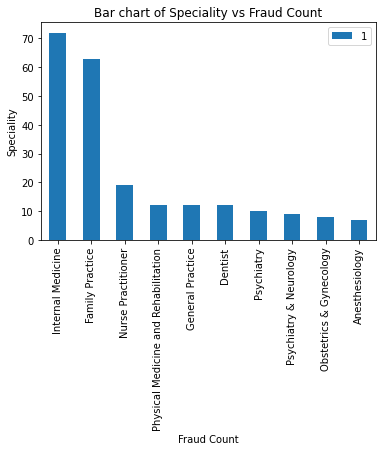

In [63]:
# plot barchart
Features_pivot_df.plot(x='Speciality', y='1', rot= 90, kind="bar")
#plot.xticks(rotation=45, horizontalalignment="center")
plt.figsize=(30,30)
plt.title("Bar chart of Speciality vs Fraud Count")
plt.ylabel("Speciality")
plt.xlabel("Fraud Count")

In [64]:
# y = FeaturesAll_pd.select(y_var) # CHECK - obsolete step
# X = FeaturesAll_pd[x_vars] # CHECK - obsolete step

# Modelling of Dataset

In [65]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [66]:
from pyspark.sql.functions import rand

# Add a column of random values to the dataframe
df = FeaturesAll_pd.withColumn('rand', rand())

# Split the dataframe into training and validation sets
X_train = df.filter('rand <= 0.8')
X_valid = df.filter('rand > 0.8')

# Remove the random column
X_train = X_train.drop('rand')
X_valid = X_valid.drop('rand')

In [67]:
print("Shape of X_train:")
print((X_train.count(), len(X_train.columns)))

print("\nShape of X_valid:")
print((X_valid.count(), len(X_valid.columns)))

Shape of X_train:
(896617, 21)

Shape of X_valid:
(224887, 21)


In [68]:
print("Count of '1' in X_train:")
print(X_train.where(Features_pd1.is_fraud == 1).count())

print("\nCount of '1' in X_valid:")
print(X_valid.where(Features_pd1.is_fraud == 1).count())

Count of '1' in X_train:
239

Count of '1' in X_valid:
62


In [69]:
X_train = X_train.na.fill(value=0)
X_valid = X_valid.na.fill('NA', categorical_features)

In [70]:
print("\nCount of nulls in train dataframe for each column:")
print(X_train.select([count(when(F.col(c).isNull(),c)).alias(c) for c in X_train.columns]) \
      .show(vertical = True))


Count of nulls in train dataframe for each column:
-RECORD 0----------------------
 Prscrbr_NPI             | 0   
 Tot_Drug_Cst_sum        | 0   
 Tot_Drug_Cst_mean       | 0   
 Tot_Drug_Cst_max        | 0   
 GE65_Tot_Clms_sum       | 0   
 GE65_Tot_Clms_mean      | 0   
 GE65_Tot_Clms_max       | 0   
 GE65_Tot_Day_Suply_sum  | 0   
 GE65_Tot_Day_Suply_mean | 0   
 GE65_Tot_Day_Suply_max  | 0   
 city                    | 0   
 state                   | 0   
 Prscrbr_State_FIPS      | 4   
 last_name               | 0   
 first_name              | 12  
 Speciality              | 1   
 Total_Payment_Sum       | 0   
 is_fraud                | 0   
 drug_max-mean           | 0   
 claim_max-mean          | 0   
 supply_max-mean         | 0   

None


In [71]:
print("\nCount of nulls in valid dataframe for each column:")
print(X_valid.select([count(when(F.col(c).isNull(),c)).alias(c) for c in X_valid.columns]) \
      .show(vertical = True))


Count of nulls in valid dataframe for each column:
-RECORD 0-------------------------
 Prscrbr_NPI             | 0      
 Tot_Drug_Cst_sum        | 6      
 Tot_Drug_Cst_mean       | 6      
 Tot_Drug_Cst_max        | 6      
 GE65_Tot_Clms_sum       | 47862  
 GE65_Tot_Clms_mean      | 47862  
 GE65_Tot_Clms_max       | 47862  
 GE65_Tot_Day_Suply_sum  | 47862  
 GE65_Tot_Day_Suply_mean | 47862  
 GE65_Tot_Day_Suply_max  | 47862  
 city                    | 0      
 state                   | 0      
 Prscrbr_State_FIPS      | 2      
 last_name               | 0      
 first_name              | 0      
 Speciality              | 0      
 Total_Payment_Sum       | 134378 
 is_fraud                | 0      
 drug_max-mean           | 6      
 claim_max-mean          | 47862  
 supply_max-mean         | 47862  

None


In [72]:
# convert to pandas df
X_train_pandas_df = X_train.toPandas()

In [73]:
X_valid_pandas_df = X_valid.toPandas()

In [74]:
type(X_train_pandas_df)

pandas.core.frame.DataFrame

In [75]:
y_train_pdf = X_train_pandas_df[y_var]
y_valid_pdf = X_valid_pandas_df[y_var]

X_train_pdf = X_train_pandas_df[x_vars]
X_valid_pdf = X_valid_pandas_df[x_vars]

In [76]:
print("Shape of training dataset x & y :",((X_train_pdf.shape), (y_train_pdf.shape)))
print("Shape of testing dataset x & y:",((X_valid_pdf.shape), (y_valid_pdf.shape)))

Shape of training dataset x & y : ((896579, 19), (896579, 1))
Shape of testing dataset x & y: ((224925, 19), (224925, 1))


In [77]:
X_train_pdf[numerical_features] = X_train_pdf.loc[:,numerical_features].fillna(0) 
X_valid_pdf[numerical_features] = X_valid_pdf.loc[:,numerical_features].fillna(0) 
X_train_pdf[categorical_features] = X_train_pdf.loc[:,categorical_features].fillna('NA') 
X_valid_pdf[categorical_features] = X_valid_pdf.loc[:,categorical_features].fillna('NA')

C:\Users\nchhat2\AppData\Local\Temp\ipykernel_12700\4025827537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_pdf[numerical_features] = X_train_pdf.loc[:,numerical_features].fillna(0)
C:\Users\nchhat2\AppData\Local\Temp\ipykernel_12700\4025827537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_pdf[numerical_features] = X_valid_pdf.loc[:,numerical_features].fillna(0)
C:\Users\nchhat2\AppData\Local\Temp\ipykernel_12700\4025827537.py:3: SettingWithCopyWarning: 
A value is trying to be 

In [78]:
print("X_train_pdf nulls:\n",X_train_pdf.isnull().sum())
print("\nX_valid_pdf nulls:\n",X_valid_pdf.isnull().sum())

X_train_pdf nulls:
 Prscrbr_NPI                0
last_name                  0
first_name                 0
Speciality                 0
city                       0
state                      0
Tot_Drug_Cst_sum           0
Tot_Drug_Cst_mean          0
Tot_Drug_Cst_max           0
GE65_Tot_Clms_sum          0
GE65_Tot_Clms_mean         0
GE65_Tot_Clms_max          0
GE65_Tot_Day_Suply_sum     0
GE65_Tot_Day_Suply_mean    0
GE65_Tot_Day_Suply_max     0
claim_max-mean             0
supply_max-mean            0
drug_max-mean              0
Total_Payment_Sum          0
dtype: int64

X_valid_pdf nulls:
 Prscrbr_NPI                0
last_name                  0
first_name                 0
Speciality                 0
city                       0
state                      0
Tot_Drug_Cst_sum           0
Tot_Drug_Cst_mean          0
Tot_Drug_Cst_max           0
GE65_Tot_Clms_sum          0
GE65_Tot_Clms_mean         0
GE65_Tot_Clms_max          0
GE65_Tot_Day_Suply_sum     0
GE65_Tot_Day_Suply

In [79]:
scaler= StandardScaler() 
X_train_pdf[numerical_features] = scaler.fit_transform(X_train_pdf[numerical_features].values)
X_valid_pdf[numerical_features] = scaler.transform(X_valid_pdf[numerical_features].values)

C:\Users\nchhat2\AppData\Local\Temp\ipykernel_12700\1046930032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_pdf[numerical_features] = scaler.fit_transform(X_train_pdf[numerical_features].values)
C:\Users\nchhat2\AppData\Local\Temp\ipykernel_12700\1046930032.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid_pdf[numerical_features] = scaler.transform(X_valid_pdf[numerical_features].values)


In [80]:
print(X_train_pdf[numerical_features].dtypes)

Tot_Drug_Cst_sum           float64
Tot_Drug_Cst_mean          float64
Tot_Drug_Cst_max           float64
GE65_Tot_Clms_sum          float64
GE65_Tot_Clms_mean         float64
GE65_Tot_Clms_max          float64
GE65_Tot_Day_Suply_sum     float64
GE65_Tot_Day_Suply_mean    float64
GE65_Tot_Day_Suply_max     float64
claim_max-mean             float64
supply_max-mean            float64
drug_max-mean              float64
Total_Payment_Sum          float64
dtype: object


In [81]:
X_train_pdf_temp = X_train_pdf[numerical_features]
y_train_pdf_temp = y_train_pdf

X_valid_pdf_temp = X_valid_pdf[numerical_features]
y_valid_pdf_temp = y_valid_pdf

In [82]:
params_0 = {'n_estimators': 100, 'max_depth': 8, 'min_samples_split': 3, 'learning_rate': 0.01}
params_1 = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 5, 'class_weight' : {0:1, 1:2514}, 'n_jobs':5}

scaler = StandardScaler()
    
clfs = [
    LogisticRegression(C=1e5,class_weight= {0:1, 1:2514}, n_jobs=5),
    
    GaussianNB(),

    ensemble.RandomForestClassifier(**params_1),

    ensemble.ExtraTreesClassifier(**params_1),
    
    ensemble.GradientBoostingClassifier(**params_0)
    
    ]

In [84]:
prob_result = []
df_m = []
clfs_fited = []
for clf in clfs:
    print("%s:" %  clf.__class__.__name__)
    clf.fit(X_train_pdf_temp,y_train_pdf_temp)
    clfs_fited.append(clf)
    y_pred = clf.predict(X_valid_pdf_temp)
    prob_pos  = clf.predict_proba(X_valid_pdf_temp)[:, 1]
    prob_result.append(prob_pos)
    m = confusion_matrix(y_valid_pdf_temp, y_pred)
    #clf_score = brier_score_loss(y_valid_pdf_temp, prob_pos, pos_label=y_valid_pdf_temp.max())
    #print("\tBrier: %1.5f" % (clf_score))
    print("\tPrecision: %1.5f" % precision_score(y_valid_pdf_temp, y_pred))
    print("\tRecall: %1.5f" % recall_score(y_valid_pdf_temp, y_pred))
    print("\tF1: %1.5f" % f1_score(y_valid_pdf_temp, y_pred))
    print("\tauc: %1.5f" % roc_auc_score(y_valid_pdf_temp, prob_pos))
    print("\tAccuracy: %1.5f\n" % accuracy_score(y_valid_pdf_temp, y_pred))
    df_m.append(
        pd.DataFrame(m, index=['True Negative', 'True Positive'], columns=['Pred. Negative', 'Pred. Positive'])
        )

LogisticRegression:


C:\Users\nchhat2\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	Precision: 0.00058
	Recall: 0.26866
	F1: 0.00115
	auc: 0.62643
	Accuracy: 0.86088

GaussianNB:


C:\Users\nchhat2\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\nchhat2\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Precision: 0.00000
	Recall: 0.00000
	F1: 0.00000
	auc: 0.59096
	Accuracy: 0.99970

RandomForestClassifier:


C:\Users\nchhat2\AppData\Local\Temp\ipykernel_12700\4119342834.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_pdf_temp,y_train_pdf_temp)


	Precision: 0.01916
	Recall: 0.16418
	F1: 0.03432
	auc: 0.67990
	Accuracy: 0.99725

ExtraTreesClassifier:


C:\Users\nchhat2\AppData\Local\Temp\ipykernel_12700\4119342834.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_pdf_temp,y_train_pdf_temp)


	Precision: 0.00313
	Recall: 0.14925
	F1: 0.00613
	auc: 0.65353
	Accuracy: 0.98558

GradientBoostingClassifier:


C:\Users\nchhat2\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	Precision: 0.20635
	Recall: 0.19403
	F1: 0.20000
	auc: 0.66574
	Accuracy: 0.99954



In [85]:
# y_train_pdf_temp.head
# print(y_train_pdf_temp.shape)
# print(type(y_train_pdf_temp))

# y_valid_pdf_temp.head()
# y_valid_pdf_temp.columns.values
# y_valid_pdf_temp[y_valid_pdf_temp['is_fraud'] == 1].count()
# y_valid_pdf[y_valid_pdf['is_fraud'] == 1].count()
# print(X_valid.where(X_valid.is_fraud == 1).count())
# len(X_valid_pandas_df[X_valid_pandas_df['is_fraud'] == 1])

# print(prob_result)
# print(prob_result[2])

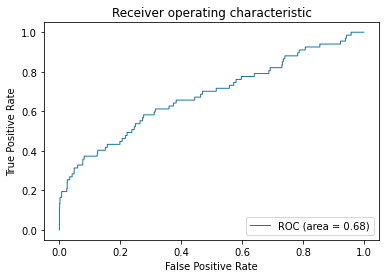

In [86]:
# plot ROC Curve

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_valid_pdf_temp, prob_result[2])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % roc_auc)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [87]:
# plot feature importance

feature_importance = clfs_fited[2].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

features = [numerical_features[ix] for ix in sorted_idx]
bardata = {"name":features[::-1], "importance percent":feature_importance[sorted_idx][::-1]}

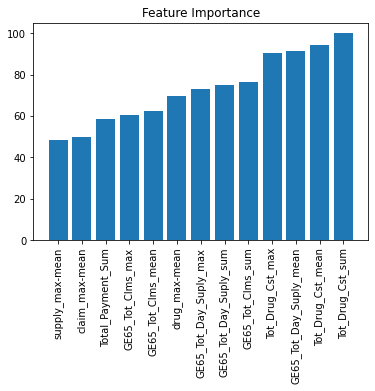

In [88]:
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X_train_pdf_temp.shape[1]), feature_importance[sorted_idx])

# Add feature names as x-axis labels
plt.xticks(range(X_train_pdf_temp.shape[1]), features, rotation=90)

# Show plot
plt.show()

In [89]:
# print(df_m)
# print(df_m[2])

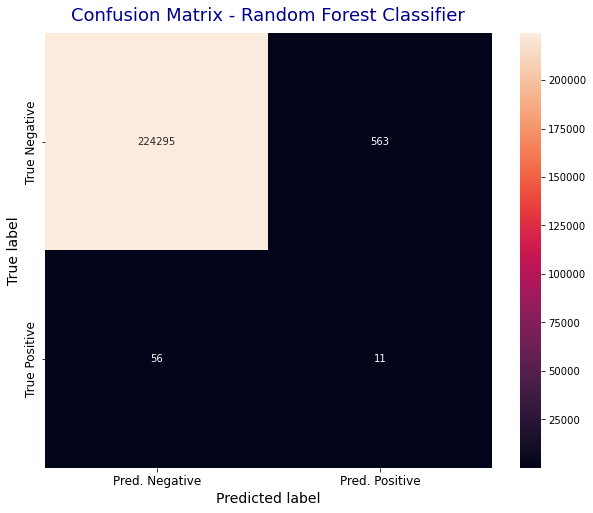

In [90]:
# plot heatmap

import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 8))
cf_heatmap = sns.heatmap(data = df_m[2], annot=True, ax = ax, fmt = 'd')
cf_heatmap.yaxis.set_ticklabels(cf_heatmap.yaxis.get_ticklabels(), fontsize = 12)
cf_heatmap.xaxis.set_ticklabels(cf_heatmap.xaxis.get_ticklabels(), fontsize = 12)

plt.title(f"Confusion Matrix - Random Forest Classifier", fontsize = 18, pad = 12, color = 'darkblue')
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)
plt.show()